# The search for nearest-neighbors between (two) mock catalogs

As a first step in working over the cross-matching of two astronomical catalogs, below I experiment a nearest-neighbor (NN) method using two sets of artificial sources.

At the first part of this notebook I generate the (mock) sources and then search for the (positional) matching pairs.

TOC:
* [Simulation of source images](#Simulation-of-source-images)
  * [Resultant simulation for the first image/catalog](#Result-of-the-simulation-for-the-first-image)
  * [Resultant simulation for the second image/catalog](#Result-of-the-simulation-for-the-second-image)
  * [Resultant merged images](#Merge-images)
* [Cross-match the tables](#Finally-cross-match-the-catalogs)

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import cm

import numpy

plt.rcParams['figure.figsize'] = (10.0, 10.0) 

## Simulation of source images

Object (or "sources") in astronomical catalogs come from the processing of astronomical images through a detection algorithm. It is out the scope here to discuss such detection algorithms, as such we generate the sources across a region mocking some region of the sky. The images help us to see what were are going to process, and by all means add to the quality/completeness of the workflow.

In [2]:
# Define parameters for the images and sources therein.

# size of the images
sx = 500
sy = 500

# number of sources on each image
nsrc1 = int( 0.05 * (sx*sy)/(sx+sy) )
nsrc2 = int( 0.5 * nsrc1 )

# typical error radius (in pixels)
rerr1 = 20
rerr2 = rerr1

In [3]:
def generate_positions(npts,img_shape):
    """
    Generate 'npts' points uniformly across 'image_shape'.
    
    Args:
        npts      : number of points to generate
        img_shape : (y,x) shape where to generate points

    Returns:
        Pair_Coordinates_List : list of (y,x) tuples
    """
    import numpy as np
    _sy,_sx = img_shape
    assert _sy>=5 and _sx>=5 # because I want
    indy = np.random.randint(0,_sy-1,npts)
    indx = np.random.randint(0,_sx-1,npts)
    _inds = zip(indy,indx)
    return _inds

# "sources 1"
coords1 = generate_positions(nsrc1,(sy,sx))
assert isinstance(coords1,list) and len(coords1) is nsrc1

In [4]:
# Below are utility functions just to handle an properly format
#  the position table to be used -- first, as a dictionary -- by the image generation function
#  and then -- as a pandas.DataFrame -- through the rest of the work

def create_positions_table(coords,err_radius):
    """
    """
    tab = {}
    for i,oo in enumerate(coords):
        i = i+1
        tab[i] = [i,oo[1],oo[0],err_radius]
    return tab

# table for "sources 1"
tab1 = create_positions_table(coords1,rerr1)

def tab2df(tab):
    nt = {'ID':[],'x':[],'y':[],'r':[]}
    for k,v in tab.iteritems():
        nt['ID'].append(v[0])
        nt['x'].append(v[1])
        nt['y'].append(v[2])
        nt['r'].append(v[3])
    import pandas
    df = pandas.DataFrame(nt)
    return df

df1 = tab2df(tab1)

In [5]:
# create and draw each source on black(null) images
def draw_image_sources(tab_positions,img_shape,colormap='colorful'):
    """
    Returns a ~PIL.Image with the objects draw in it
    
    Input:
     - tab_positions : dict()
             dictionary with keys as row numbers (index)
             and as values a tuple (index,x_position,y_position,radius)
     - img_shape : tuple
             tuple with (y,x) sizes, as a ~numpy.array.shape output
     - colomap : str
             name of the colormap to use: {colorful, blue, red, green}
             
    Output:
     - tuple with: ~PIL.Image with the sources(circles) draw
                 , a dictionary with identifiers for each source (internal use only)
    """
    def color_filling(mode='colorful'):
        def _colorful(x,y,size):
            _R = int(255 - ( int(x/256) + int(y/256)*(1 + ceil(size[0]/256)) )) #TODO: restrict total size of image to avoid _R<=0
            _G = x%256
            _B = y%256
            return (_R,_G,_B)

        def _blue(x,y,size):
            _R = 0
            _G = 0
            _B = 255
            return (_R,_G,_B)

        def _green(x,y,size):
            _R = 0
            _G = 255
            _B = 0
            return (_R,_G,_B)

        def _red(x,y,size):
            _R = 255
            _G = 0
            _B = 0
            return (_R,_G,_B)

        foos = {'blue'    : _blue,
                'red'     : _red,
                'green'   : _green,
                'colorful': _colorful}
        
        try:
            foo = foos[mode]
        except:
            foo = _colorful
        return foo
        
        
    from math import ceil
    from PIL import Image,ImageDraw
    assert(isinstance(img_shape,tuple) and len(img_shape) is 2)
    size = img_shape[::-1]
    # Modification to accomplish color codes ---
    #mode = 'L'
    mode = 'RGB'
    # ---
    color = "black"
    img = Image.new(mode,size,color)
    assert(len(tab_positions)>=1)
    #
    dictColorId = {}
    filling_foo = color_filling(colormap)
    #
    for i,src in tab_positions.items():
        assert isinstance(src,list) and src is tab_positions[i]
        assert len(src)>=4, "length of table raw %d is %d" % (i,len(src))
        assert i==src[0]
        draw = ImageDraw.Draw(img)
        x = src[1]
        assert 0<=x and x<size[0], "coordinate x is %d" % x
        y = src[2]
        assert 0<=y and y<size[1], "coordinate y is %d" % y
        r = src[3]
        assert r<size[0]/2 and r<size[1]/2
        box = (x-r,y-r,x+r,y+r)
        # Modification to accomplish color codes ---
        #fill=255
        fill = filling_foo(x,y,size)
        # ---
        dictColorId[str(fill)] = i
        draw.ellipse(box,fill=fill)
        del draw,box,x,y,r
    return (img,dictColorId)

img1,cor2id1 = draw_image_sources(tab1,(sy,sx),colormap='blue')
#img1.show()

In [6]:
## Utility functions to handle convertion between PIL -> numpy, to show it with Matplotlib
#

# cmap reference:
#
# cm api: http://matplotlib.org/api/cm_api.html
# cmaps : http://matplotlib.org/users/colormaps.html
# imshow: http://matplotlib.org/users/image_tutorial.html
#cmap = cm.get_cmap('Blues')

def pilImage_2_numpyArray(img,shape):
    sx,sy = shape
    img_array = numpy.array(list(img.getdata())).reshape(sx,sy,3)
    return img_array

def rgbArray_2_mono(img_arr,chanel='R'):
    chanels = {'R':0,
               'G':1,
               'B':2}
    _i = chanels[chanel]
    return img_arr[:,:,_i]


### Result of the simulation for the first image

Catalog A:
----------
    ID   r    x    y
0    1  20  261  381
1    2  20  255  439
2    3  20   66  130
3    4  20  172  413
4    5  20  450  174
5    6  20  479  107
6    7  20  315   46
7    8  20  255  171
8    9  20  203  130
9   10  20   72   41
10  11  20  484  336
11  12  20   41   55


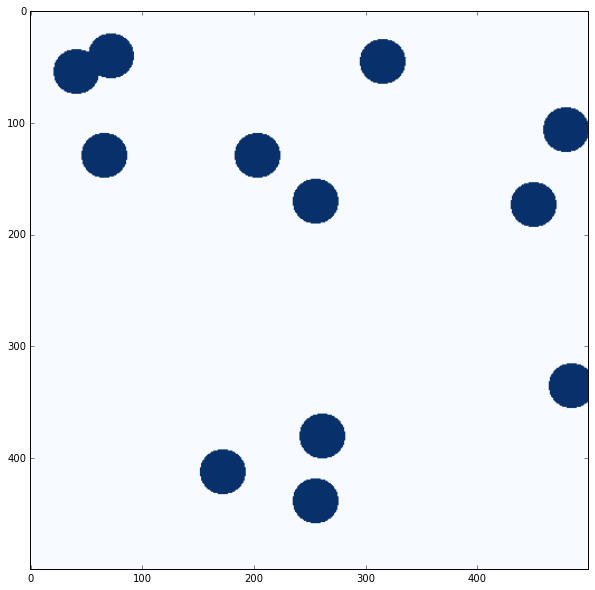

In [7]:
img1_array = pilImage_2_numpyArray(img1,[sx,sy])
img1_mono = rgbArray_2_mono(img1_array,'B')

plt.imshow(img1_mono,cmap='Blues')
print "Catalog A:"
print "----------"
print df1

In [8]:
# do the same steps for "sources 2"
coords2 = generate_positions(nsrc2,(sy,sx))
assert isinstance(coords2,list) and len(coords2) is nsrc2
tab2 = create_positions_table(coords2,rerr2)
img2,cor2id2 = draw_image_sources(tab2,(sy,sx),colormap='red')
#img2.show()
df2 = tab2df(tab2)

### Result of the simulation for the second image

Catalog B:
----------
   ID   r    x    y
0   1  20  444  368
1   2  20  456  212
2   3  20  298  273
3   4  20   69  443
4   5  20   46  335
5   6  20  244  171


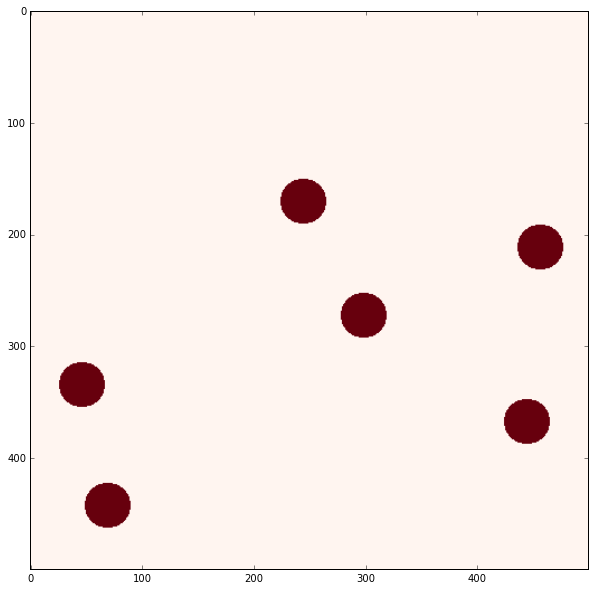

In [9]:
img2_array = pilImage_2_numpyArray(img2,[sx,sy])
img2_mono = rgbArray_2_mono(img2_array,'R')

print "Catalog B:"
print "----------"
print df2
plt.imshow(img2_mono,cmap='Reds')

### Merge images

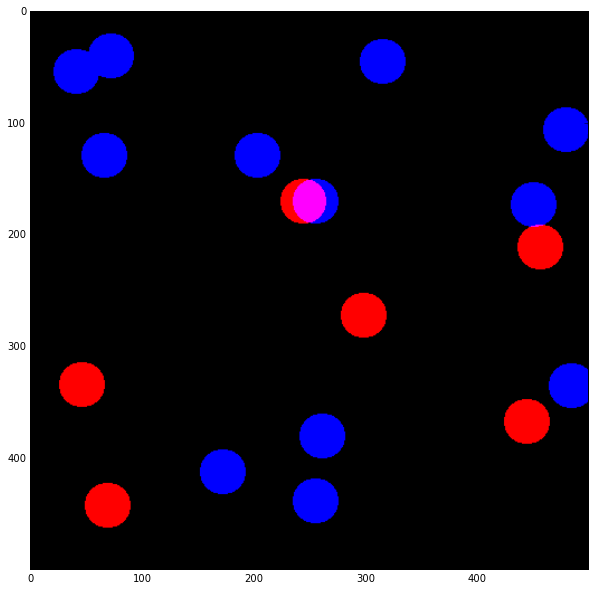

In [10]:
def add_arrays_2_image(img1,img2):
    """
    """
    def array_2_image(arr):
        from PIL import Image
        imgout = Image.fromarray(numpy.uint8(arr))
        return imgout
    return array_2_image(img1+img2)

img_sum = add_arrays_2_image(img1_array,img2_array)
plt.imshow(img_sum)

## Finally cross-match the catalogs

In [11]:
def nn_search(catA,catB):
    """
    """
    
    import pandas
    assert isinstance(catA,pandas.DataFrame)
    assert isinstance(catB,pandas.DataFrame)
    
    A = catA.copy()
    B = catB.copy()
    
    from astropy.coordinates import SkyCoord
    from astropy import units
    norm_fact = 500.0
    Ax_norm = A.x / norm_fact
    Ay_norm = A.y / norm_fact
    A_coord = SkyCoord(ra=Ax_norm, dec=Ay_norm, unit=units.deg)

    Bx_norm = B.x / norm_fact
    By_norm = B.y / norm_fact
    B_coord = SkyCoord(ra=Bx_norm, dec=By_norm, unit=units.deg)

    from astropy.coordinates import match_coordinates_sky
    match_A_nn_idx, match_A_nn_sep, _d3d = match_coordinates_sky(A_coord, B_coord)
    match_B_nn_idx, match_B_nn_sep, _d3d = match_coordinates_sky(B_coord, A_coord)


    A['NN_in_B'] = B.ID[match_A_nn_idx].values
    B['NN_in_A'] = A.ID[match_B_nn_idx].values

    import numpy
    A_matched_pairs = zip(numpy.arange(len(match_A_nn_idx)),
                          match_A_nn_idx )
    B_matched_pairs = set(zip(match_B_nn_idx,
                              numpy.arange(len(match_B_nn_idx))))

    duplicate_pairs = []
    duplicate_dists = []
    for i,p in enumerate(A_matched_pairs):
        if p in B_matched_pairs:
            duplicate_pairs.append(p)
            duplicate_dists.append(match_A_nn_sep[i].value)

    A_matched_idx,B_matched_idx = zip(*duplicate_pairs)
    df_matched = pandas.DataFrame({ 'A_idx':A_matched_idx,
                                    'B_idx':B_matched_idx,
                                    'separation':duplicate_dists})
    df_matched = df_matched.set_index('A_idx')

    A.columns = [ 'A_'+c for c in A.columns ]
    B.columns = [ 'B_'+c for c in B.columns ]

    B_matched = B.iloc[df_matched.B_idx]
    B_matched['A_idx'] = df_matched.index
    B_matched = B_matched.set_index('A_idx')

    B_matched['dist'] = numpy.asarray(df_matched.separation * norm_fact, dtype=int)

    df = pandas.concat([A,B_matched],axis=1)
    return df

from astropy.table import Table
table_match = Table.from_pandas( nn_search(df1,df2) )
table_match.show_in_notebook()

/home/chbrandt/.conda/envs/booq-dev/lib/python2.7/site-packages/ipykernel/__main__.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


A_ID,A_r,A_x,A_y,A_NN_in_B,B_ID,B_r,B_x,B_y,B_NN_in_A,dist
1,20,261,381,3,--,--,--,--,--,--
2,20,255,439,3,--,--,--,--,--,--
3,20,66,130,6,--,--,--,--,--,--
4,20,172,413,4,4.0,20.0,69.0,443.0,4.0,107.0
5,20,450,174,2,2.0,20.0,456.0,212.0,5.0,38.0
6,20,479,107,2,--,--,--,--,--,--
7,20,315,46,6,--,--,--,--,--,--
8,20,255,171,6,6.0,20.0,244.0,171.0,8.0,10.0
9,20,203,130,6,--,--,--,--,--,--
10,20,72,41,6,--,--,--,--,--,--
